<a href="https://colab.research.google.com/github/ttya16/kaggle_LANL_Earthquake_Prediction/blob/master/kaggle_LANL_earthquake_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## LANL-Earthquake-Prediction  
Referenced some ideas for feature engineering and dataset overview from [Kaggle kernels](https://www.kaggle.com/c/LANL-Earthquake-Prediction/kernels)


##方針・概要
地震波データを150000ごとに区切って特徴量をいくつか計算し、
その時点での次の地震発生までの時間(TTF、time to failure)を予測する。GradientBoosting、XGBoost、RNN(GRU)のモデルで学習させてそれぞれの結果を比較した。
![image](https://raw.githubusercontent.com/ttya16/kaggle_LANL_Earthquake_Prediction/master/earthquake_ttf_prediction.png?token=AtZ-H8RAzvYXKBsYHKSZMgboulZmmjlSks5ckqcpwA%3D%3D)

##データセットの準備
Colabにデータセットをダウンロードするフェーズ<br>
ローカルでやる場合は不要

In [1]:
#kaggleコンペのデータをダウンロードするための準備
!pip install kaggle
!pip install numpy==1.16.0 #numpy.quantileを使いたいため

    100% |████████████████████████████████| 17.3MB 2.3MB/s 
featuretools 0.4.1 has requirement pandas>=0.23.0, but you'll have pandas 0.22.0 which is incompatible.
datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
  Found existing installation: numpy 1.14.6
    Uninstalling numpy-1.14.6:
      Successfully uninstalled numpy-1.14.6


In [1]:
#import data files from kaggle
from google.colab import files
uploaded = files.upload()

!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/kaggle/kaggle.json

Saving kaggle.json to kaggle.json
chmod: cannot access '/root/kaggle/kaggle.json': No such file or directory


In [2]:
!kaggle competitions list

ref                                            deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       2557           False  
titanic                                        2030-01-01 00:00:00  Getting Started  Knowledge      10260            True  
house-prices-advanced-regression-techniques    2030-01-01 00:00:00  Getting Started  Knowledge       4054           False  
imagenet-object-localization-challenge         2029-12-31 07:00:00  Research         Knowledge         36           False  
competitive-data-science-predict-future-sales  2019-12-31 23:59:00  Playground           Kudos       2559           False  
two-sigma-financial-news                       2019-07-15 23:59:00  Featured          $100,000       2927           False  
aerial-c

In [3]:
#download the Earthquake data
!kaggle competitions download -c LANL-Earthquake-Prediction

  0% 0.00/33.3k [00:00<?, ?B/s]
100% 33.3k/33.3k [00:00<00:00, 28.9MB/s]
 92% 223M/242M [00:01<00:00, 159MB/s]
100% 242M/242M [00:01<00:00, 157MB/s]
100% 2.03G/2.03G [00:18<00:00, 151MB/s]
100% 2.03G/2.03G [00:19<00:00, 114MB/s]


In [4]:
#Dowloadした訓練用ファイルを展開
!unzip train.csv.zip
!ls

Archive:  train.csv.zip
  inflating: train.csv               
sample_data  sample_submission.csv  test.zip  train.csv  train.csv.zip


##EDA
[これ](https://www.kaggle.com/artgor/seismic-data-eda-and-baseline)
とか参照

In [0]:
import numpy as np
import pandas as pd

In [2]:
%%time
train = pd.read_csv('train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})
print(train.shape)

(629145480, 2)
CPU times: user 2min 46s, sys: 44.3 s, total: 3min 31s
Wall time: 3min 44s


In [0]:
train_acoustic_data_small = train['acoustic_data'].values[::50]
train_time_to_failure_small = train['time_to_failure'].values[::50]

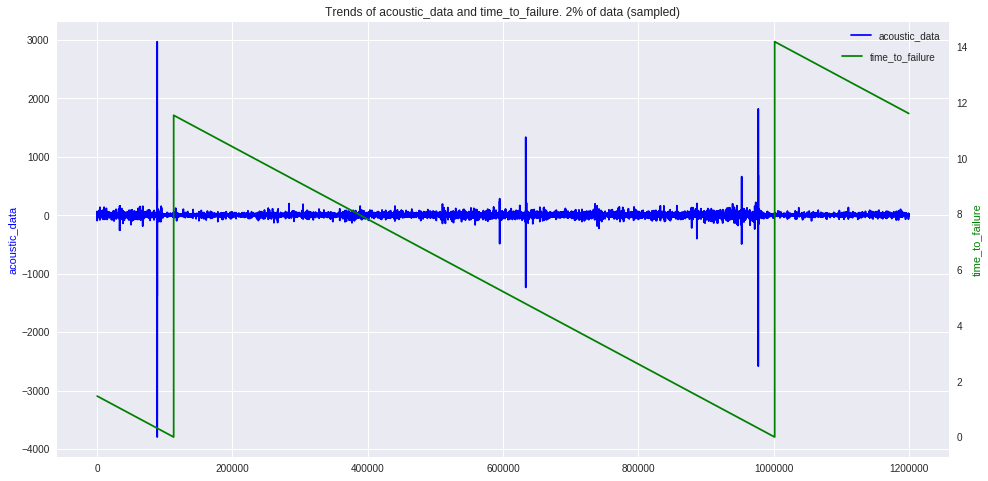

In [0]:
#visualize data
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("Trends of acoustic_data and time_to_failure. 2% of data (sampled)")
plt.plot(train_acoustic_data_small, color='b')
ax1.set_ylabel('acoustic_data', color='b')
plt.legend(['acoustic_data'])
ax2 = ax1.twinx()
plt.plot(train_time_to_failure_small, color='g')
ax2.set_ylabel('time_to_failure', color='g')
plt.legend(['time_to_failure'], loc=(0.875, 0.9))
plt.grid(False)

del train_acoustic_data_small
del train_time_to_failure_small

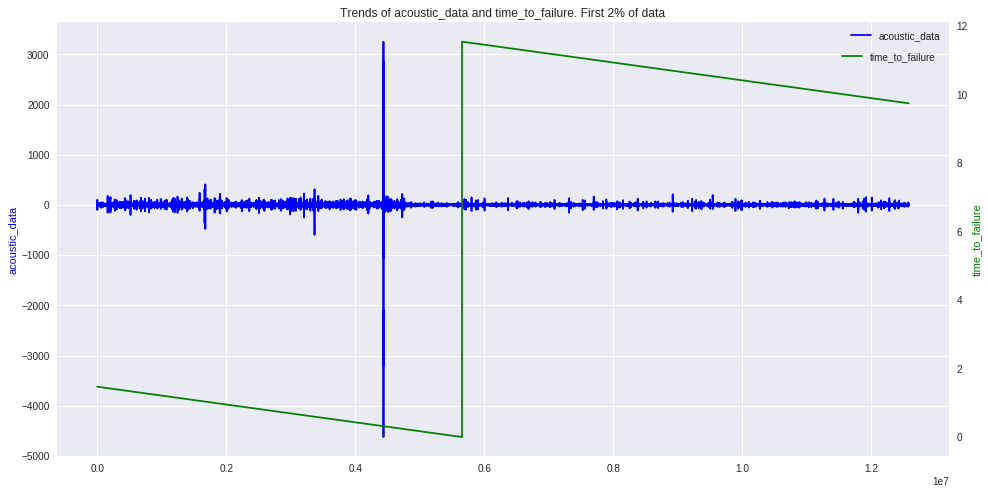

In [0]:
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("Trends of acoustic_data and time_to_failure. First 2% of data")
plt.plot(train['acoustic_data'].values[:12582910], color='b')
ax1.set_ylabel('acoustic_data', color='b')
plt.legend(['acoustic_data'])
ax2 = ax1.twinx()
plt.plot(train['time_to_failure'].values[:12582910], color='g')
ax2.set_ylabel('time_to_failure', color='g')
plt.legend(['time_to_failure'], loc=(0.875, 0.9))
plt.grid(False)

##Feature Engineering

In [0]:
#Add some statistical features to the dataset
#特徴量サンプリングとして基本的な統計量をいくつか追加してみる
#平均、標準偏差、最小値、最大値、尖度(kurtosis)、歪度(skewness)、差分 etc.

#190321 セグメントごとの端何件か（edge_rows）の平均、std、差分を特徴量として追加
#190321 minとskewはなんとなく要らなそうなので除いてみた（feature_importanceで要検証）
def gen_features(X):
    strain = []
    strain.append(X.mean())
    strain.append(X.std())
    #strain.append(X.min())
    strain.append(X.max())
    strain.append(X.median())
    strain.append(X.kurtosis())
    #strain.append(X.skew())
    strain.append(np.quantile(X, 0.01))
    strain.append(np.quantile(X, 0.05))
    strain.append(np.quantile(X, 0.95))
    strain.append(np.quantile(X, 0.99))
    strain.append(np.mean(np.diff(X)))
    
    strain.append(np.mean(np.abs(X)))
    strain.append(X.max() - X.min())
    
    #modified 19.03.21
    for edge_rows in [10000, 20000, 50000]:
      strain.append(X[:edge_rows].mean())
      strain.append(X[:edge_rows].std())
      strain.append(np.mean(np.diff(X[:edge_rows])))
      strain.append(X[-edge_rows:].mean())
      strain.append(X[-edge_rows:].std())
      strain.append(np.mean(np.diff(X[-edge_rows:])))
      
    
    #rolling data of window size 100
    #X_roll_std = X.rolling(100).std().dropna().values
    #X_roll_mean = X.rolling(100).mean().dropna().values
    
    #strain.append(X_roll_std.mean())
    #strain.append(X_roll_std.std())
    #strain.append(X_roll_std.min())
    #strain.append(X_roll_std.max())
    #strain.append(np.mean(np.diff(X_roll_std)))
    #strain.append(np.mean(np.abs(X_roll_std)))
    #strain.append(X_roll_mean.mean())
    #strain.append(X_roll_mean.std())
    #strain.append(X_roll_mean.min())
    #strain.append(X_roll_mean.max())
    #strain.append(np.mean(np.diff(X_roll_mean)))
    #strain.append(np.mean(np.abs(X_roll_mean)))

    
    return pd.Series(strain)


### 学習データ準備
メモリ対策でchunksize指定で読み込んでいく。
特徴量の計算はテストデータのサイズに合わせて150000ごとに計算する。

In [0]:
import numpy as np
import pandas as pd

train = pd.read_csv("train.csv", iterator=True, chunksize=150000, dtype={'acoustic_data':np.int16, 'time_to_failure':np.float64})

X_train = pd.DataFrame()
y_train = pd.Series()
df = pd.DataFrame()

for chunk in train:
  df = df.append(chunk)
  if len(df) >= 150000:
    df = df[-150000:]
    ch = gen_features(df['acoustic_data'])
    X_train = X_train.append(ch, ignore_index=True)
    y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
    

In [69]:
#標準化
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
print(X_train_sc.shape)
X_train_sc[0]

(4195, 30)


array([ 1.4243304 , -0.17014507, -0.2181291 ,  0.94727584, -0.49115666,
        0.22863044,  0.07886163, -0.09827707, -0.16325772, -1.32660275,
        0.01925324, -0.20797671,  2.16937428,  0.72435272, -0.3136111 ,
        0.50215526, -0.19234316, -0.26123218,  1.82203506,  0.37778815,
       -0.61996206, -0.08210127, -0.21337843, -0.3985496 ,  1.60202869,
        0.05215375, -0.6737523 ,  0.36725035, -0.28552915, -0.21040771])

In [0]:
from sklearn.model_selection import train_test_split
X_tr, X_val, y_tr, y_val = train_test_split(X_train_sc, y_train, test_size=0.1,shuffle=False)

In [71]:
print(X_tr.shape)
print(X_val.shape)

(3775, 30)
(420, 30)


In [72]:
y_train.shape

(4195,)

## Create Model & Train

### GradientBoosting

In [0]:
#勾配ブースティング
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error

gbrt = GradientBoostingRegressor(max_depth = 2, warm_start=True)

min_val_error = float("inf")
error_going_up = 0

for n_estimators in range(1, 300):
  gbrt.n_estimators = n_estimators
  gbrt.fit(X_tr, y_tr)
  y_pred = gbrt.predict(X_val)
  val_error = mean_absolute_error(y_val, y_pred)
  if val_error < min_val_error:
    min_val_error = val_error
    error_going_up = 0
  else:
    error_going_up += 1
    
  if error_going_up > 10:
    break


In [73]:
#早期打ち切りなしでやりたい場合
gbrt = GradientBoostingRegressor(max_depth = 2, n_estimators=200)
gbrt.fit(X_tr, y_tr)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=200, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

### XGBoost

In [74]:
#XGBoost
import xgboost as xgb

xgb_model = xgb.XGBRegressor(max_depth=3, n_estimators = 200)

xgb_model.fit(X_tr, y_tr)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

### RNN

In [75]:
#RNN model
from keras.models import Sequential
from keras.layers import Dense, GRU, CuDNNGRU, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint
n_features = X_tr.shape[1]

model = Sequential()
model.add(CuDNNGRU(48, input_shape=(None, n_features)))
model.add(Dense(10, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(1))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnngru_3 (CuDNNGRU)       (None, 48)                11520     
_________________________________________________________________
dense_5 (Dense)              (None, 10)                490       
_________________________________________________________________
batch_normalization_3 (Batch (None, 10)                40        
_________________________________________________________________
dropout_3 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 11        
Total params: 12,061
Trainable params: 12,041
Non-trainable params: 20
_________________________________________________________________


In [0]:
X_tr_reshaped = np.reshape(np.array(X_tr), (X_tr.shape[0], 1, X_tr.shape[1]))

In [77]:
from keras.optimizers import adam
model.compile(optimizer = adam(lr=0.005), loss='MAE')
model.fit(X_tr_reshaped, y_tr, epochs=20, batch_size=32, verbose=1)

Epoch 1/20
3775/3775 [==============================] - 1s 365us/step - loss: 4.1304
Epoch 2/20
3775/3775 [==============================] - 1s 254us/step - loss: 2.4099
Epoch 3/20
3775/3775 [==============================] - 1s 276us/step - loss: 2.3574
Epoch 4/20
3775/3775 [==============================] - 1s 256us/step - loss: 2.3194
Epoch 5/20
3775/3775 [==============================] - 1s 293us/step - loss: 2.3094
Epoch 6/20
3775/3775 [==============================] - 1s 273us/step - loss: 2.2832
Epoch 7/20
3775/3775 [==============================] - 1s 254us/step - loss: 2.2818
Epoch 8/20
3775/3775 [==============================] - 1s 288us/step - loss: 2.2724
Epoch 9/20
3775/3775 [==============================] - 1s 276us/step - loss: 2.2761
Epoch 10/20
3775/3775 [==============================] - 1s 247us/step - loss: 2.2387
Epoch 11/20
3775/3775 [==============================] - 1s 289us/step - loss: 2.2806
Epoch 12/20
3775/3775 [==============================] - 1s 280

### Plot results

GradientBoosting 2.3780927477684113
XGBoosting 2.4560076841497485
GRU 2.0637143136160563
Blend 1.9145809628439603


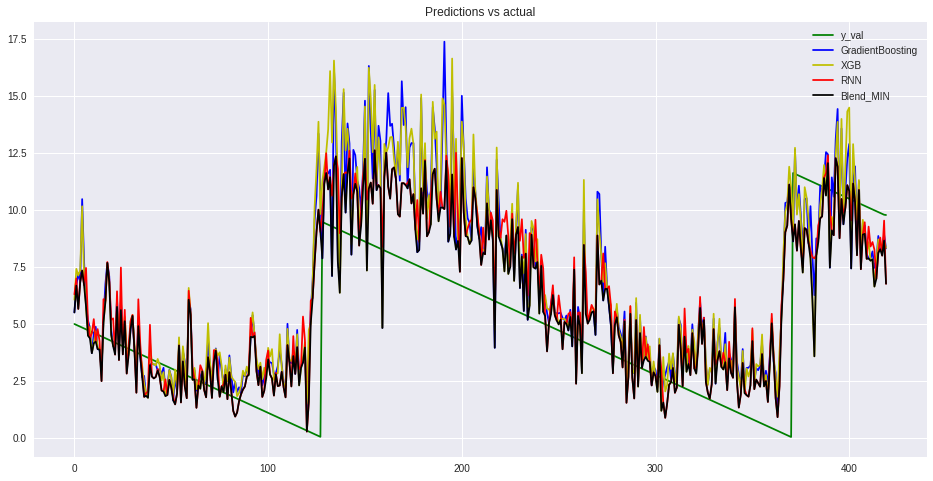

In [78]:
X_val_reshaped = np.reshape(np.array(X_val), (X_val.shape[0], 1, X_val.shape[1]))

y_pred_rnn = model.predict(X_val_reshaped)
y_pred_gbrt = gbrt.predict(X_val)
y_pred_xgb = xgb_model.predict(X_val)
y_pred_blend_min = np.minimum(np.minimum(np.reshape(y_pred_rnn, (y_pred_rnn.shape[0],)), y_pred_gbrt), y_pred_xgb)

val_error_gbrt = mean_absolute_error(y_val, y_pred_gbrt)
val_error_xgb = mean_absolute_error(y_val, y_pred_xgb)
val_error_rnn = mean_absolute_error(y_val, y_pred_rnn)
val_error_blend_min = mean_absolute_error(y_val, y_pred_blend_min)
print("GradientBoosting",val_error_gbrt)
print("XGBoosting", val_error_xgb)
print("GRU", val_error_rnn)
print("Blend", val_error_blend_min)

import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
plt.plot(np.array(y_val), color='g', label='y_val')
plt.plot(y_pred_gbrt, color='b', label='GradientBoosting')
plt.plot(y_pred_xgb, color='y', label='XGB')
plt.plot(y_pred_rnn, color='r', label='RNN')
plt.plot(y_pred_blend_min, color='k', label='Blend_MIN')
plt.legend()
plt.title('Predictions vs actual')
plt.show()

### 考察

・全体的に予測値は真の値よりも大きい傾向がある？<br>→各モデルの予測値のうち最小のものを選択した結果Blend_MIXの誤差が最小になった。<br>
・Validation Scoreはどのモデルも似たり寄ったりでそんなに良くないが、特徴量次第では変わってくるかもしれない。

## テストデータをfitさせる

In [0]:
#テストデータを展開
!unzip test.zip

In [61]:
submission = pd.read_csv('sample_submission.csv', index_col='seg_id')
X_test = pd.DataFrame()

for seg_id in submission.index:
    seg = pd.read_csv(seg_id + '.csv')
    ch = gen_features(seg['acoustic_data'])
    X_test = X_test.append(ch, ignore_index=True)

X_test = sc.fit_transform(X_test)
print(X_test.shape)

(2624, 24)


In [0]:
X_test_reshaped = np.reshape(np.array(X_test), (X_test.shape[0], 1, X_test.shape[1]))

pred_rnn = model.predict(X_test_reshaped)
pred_gbrt = gbrt.predict(X_test)
pred_xgb = xgb_model.predict(X_test)
pred_blend_min = np.minimum(np.minimum(np.reshape(pred_rnn, (pred_rnn.shape[0],)), pred_gbrt), pred_xgb)

In [0]:
submission['time_to_failure'] = pred_blend_min
submission.to_csv('submission.csv')

In [64]:
!kaggle competitions submit -c LANL-Earthquake-Prediction -f submission.csv -m "190321_blendmin"

100% 74.9k/74.9k [00:01<00:00, 52.3kB/s]
Successfully submitted to LANL Earthquake Prediction

↑Blend_MINの結果を提出してスコア1.744だった。
テストデータに偶然良くハマった可能性がある。

## Further Improvements
* 特徴量の改善？
* 学習データの整形ももっといい方法があるか？
* 別のモデル？(CatBoost, BiDirectionalRNN)